In [1]:
import tonic

dataset = tonic.datasets.NMNIST(save_to='./data', train=True)
events, target = dataset[0]

/slurm_data/youcheng.li/anaconda3/envs/ddpm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


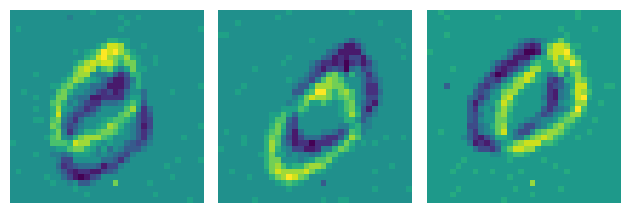

In [2]:
tonic.utils.plot_event_grid(events)

In [3]:
import tonic.transforms as transforms

sensor_size = tonic.datasets.NMNIST.sensor_size

# Denoise removes isolated, one-off events
# time_window
frame_transform = transforms.Compose([transforms.Denoise(filter_time=10000),
                                      transforms.ToFrame(sensor_size=sensor_size,
                                                         time_window=1000)
                                     ])

trainset = tonic.datasets.NMNIST(save_to='./data', transform=frame_transform, train=True)
testset = tonic.datasets.NMNIST(save_to='./data', transform=frame_transform, train=False)

In [4]:
from torch.utils.data import DataLoader
from tonic import DiskCachedDataset


cached_trainset = DiskCachedDataset(trainset, cache_path='./cache/nmnist/train')
cached_dataloader = DataLoader(cached_trainset)

batch_size = 128
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np


In [5]:
def load_sample_batched():
    events, target = next(iter(cached_dataloader))

In [6]:
import torch
import torchvision

transform = tonic.transforms.Compose([torch.from_numpy,
                                      torchvision.transforms.RandomRotation([-10,10])])

cached_trainset = DiskCachedDataset(trainset, transform=transform, cache_path='./cache/nmnist/train')

# no augmentations for the testset
cached_testset = DiskCachedDataset(testset, cache_path='./cache/nmnist/test')

batch_size = 1
# trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)

dataset_length = len(cached_trainset)
indices = np.arange(0, dataset_length, 600)
sampler = SubsetRandomSampler(indices)

trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=False, sampler=sampler)
testloader = DataLoader(cached_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False))

print(len(trainloader))

100


In [7]:
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import spikeplot as splt
from snntorch import utils
import torch.nn as nn
import torch

import os

In [8]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# neuron and simulation parameters
spike_grad = surrogate.atan()
beta = 0.5

#  Initialize Network
net = nn.Sequential(nn.Conv2d(2, 12, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Conv2d(12, 32, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Flatten(),
                    nn.Linear(32*5*5, 10),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)

In [9]:
# this time, we won't return membrane as we don't need it

def forward_pass(net, data):
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(data.size(0)):  # data.size(0) = number of time steps
      spk_out, mem_out = net(data[step])
      spk_rec.append(spk_out)

  return torch.stack(spk_rec)

In [10]:
optimizer = torch.optim.Adam(net.parameters(), lr=2e-2, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

In [11]:
from tqdm import tqdm
import numpy as np
import os
num_epochs = 1
num_iters = 10

loss_hist = []
acc_hist = []

use_pretrained = True

if os.path.exists('./model/nmnist.pth') and use_pretrained:
  net.load_state_dict(torch.load('./model/nmnist.pth'))
  print('Model loaded')
  spk_list = []
  target_list = []
  for i, (data, targets) in tqdm(enumerate(iter(trainloader))):
      data = data.to(device)
      targets = targets.to(device)

      net.eval()
      spk_rec = forward_pass(net, data)
      loss_val = loss_fn(spk_rec, targets)

      # Store loss history for future plotting
      loss_hist.append(loss_val.item())

      # print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")

      # acc = SF.accuracy_rate(spk_rec, targets)
      _, idx = spk_rec.sum(dim=0).max(1)
      spk_list.extend(idx)
      target_list.extend(targets)
      # if i == num_iters:
      #   break
  spk_list = torch.stack(spk_list).cpu().numpy()
  target_list = torch.stack(target_list).cpu().numpy()
  accuracy = np.mean(spk_list == target_list)
  acc_hist.append(accuracy)
  # print(f"Accuracy: {acc * 100:.2f}%\n")
  tqdm.write(f"Accuracy: {accuracy * 100:.2f}%\n")
else:
  # training loop
  for epoch in range(num_epochs):
      tqdm.write(f"Epoch {epoch + 1}\n-------------------------------")
      spk_list = []
      target_list = []
      for i, (data, targets) in tqdm(enumerate(iter(trainloader))):
          data = data.to(device)
          targets = targets.to(device)

          net.train()
          spk_rec = forward_pass(net, data)
          loss_val = loss_fn(spk_rec, targets)

          # Gradient calculation + weight update
          optimizer.zero_grad()
          loss_val.backward()
          optimizer.step()

          # Store loss history for future plotting
          loss_hist.append(loss_val.item())

          # print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")

          # acc = SF.accuracy_rate(spk_rec, targets)
          _, idx = spk_rec.sum(dim=0).max(1)
          spk_list.extend(idx)
          target_list.extend(targets)
          # if i == num_iters:
          #   break
      spk_list = torch.stack(spk_list).cpu().numpy()
      target_list = torch.stack(target_list).cpu().numpy()
      accuracy = np.mean(spk_list == target_list)
      acc_hist.append(accuracy)
      # print(f"Accuracy: {acc * 100:.2f}%\n")
      tqdm.write(f"Accuracy: {accuracy * 100:.2f}%\n")
          # training loop breaks after 50 iterations
          # if i == num_iters:
          #   break

torch.save(net.state_dict(), './model/nmnist.pth')

Model loaded


100it [00:54,  1.83it/s]

Accuracy: 59.00%



Accuracy: 0.59
Accuracy for class 0: 0.9
Accuracy for class 1: 1.0
Accuracy for class 2: 0.7
Accuracy for class 3: 0.3
Accuracy for class 4: 1.0
Accuracy for class 5: 0.1
Accuracy for class 6: 0.7777777777777778
Accuracy for class 7: 0.5454545454545454
Accuracy for class 8: 0.2
Accuracy for class 9: 0.3333333333333333


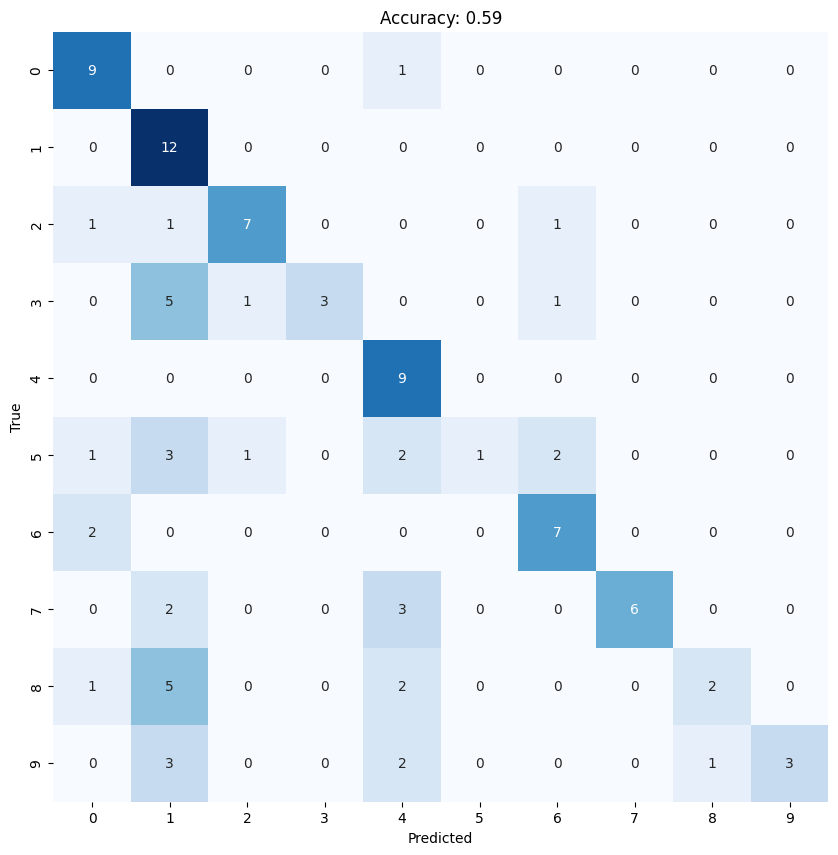

In [12]:
# acc per class
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

pred = spk_list
target = target_list

cm = confusion_matrix(target, pred)
acc = accuracy_score(target, pred)

print(f'Accuracy: {acc}')

for i in range(10):
  print(f'Accuracy for class {i}: {cm[i,i]/cm[i,:].sum()}')

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Accuracy: {acc}')
plt.savefig('./figures/nmnist_confusion_matrix.png')
# plt.show()



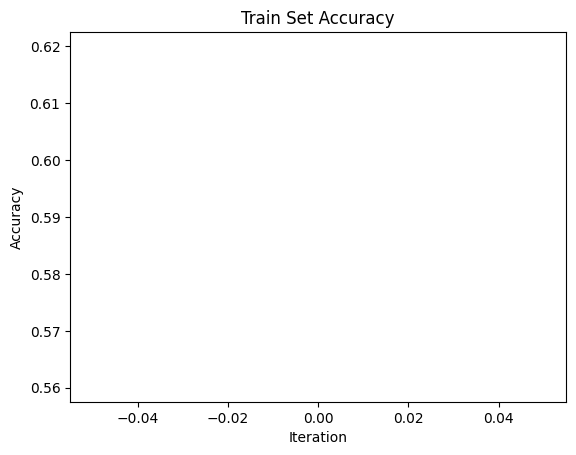

In [13]:
import matplotlib.pyplot as plt

# Plot Loss
fig = plt.figure(facecolor="w")
plt.plot(acc_hist)
plt.title("Train Set Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

The target label is: 4


  1%|          | 1/100 [00:00<00:49,  1.99it/s]

The target label is: 1


  2%|▏         | 2/100 [00:00<00:48,  2.02it/s]

The target label is: 2


  3%|▎         | 3/100 [00:01<00:47,  2.04it/s]

The target label is: 9


  4%|▍         | 4/100 [00:01<00:47,  2.02it/s]

The target label is: 0


  5%|▌         | 5/100 [00:02<00:47,  2.02it/s]

The target label is: 7


  7%|▋         | 7/100 [00:03<00:35,  2.61it/s]

The target label is: 5


 19%|█▉        | 19/100 [00:03<00:07, 10.51it/s]

The target label is: 8
The target label is: 3


 22%|██▏       | 22/100 [00:04<00:12,  6.30it/s]

The target label is: 6


 22%|██▏       | 22/100 [00:05<00:18,  4.23it/s]


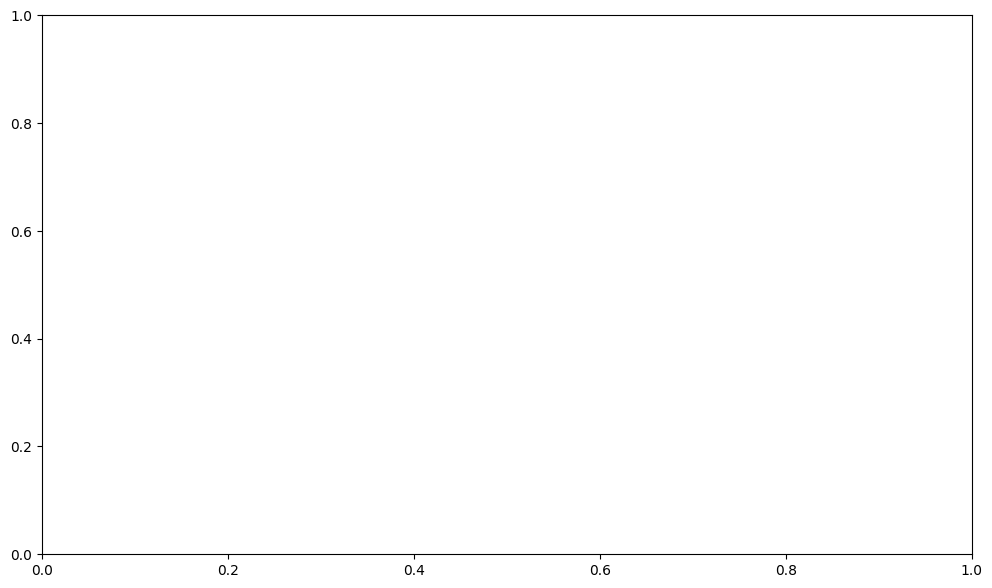

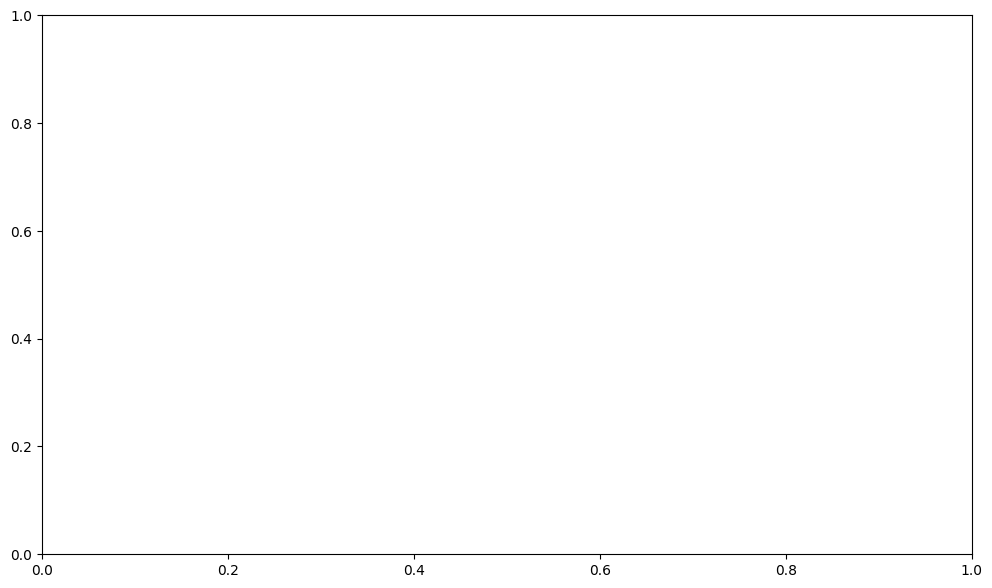

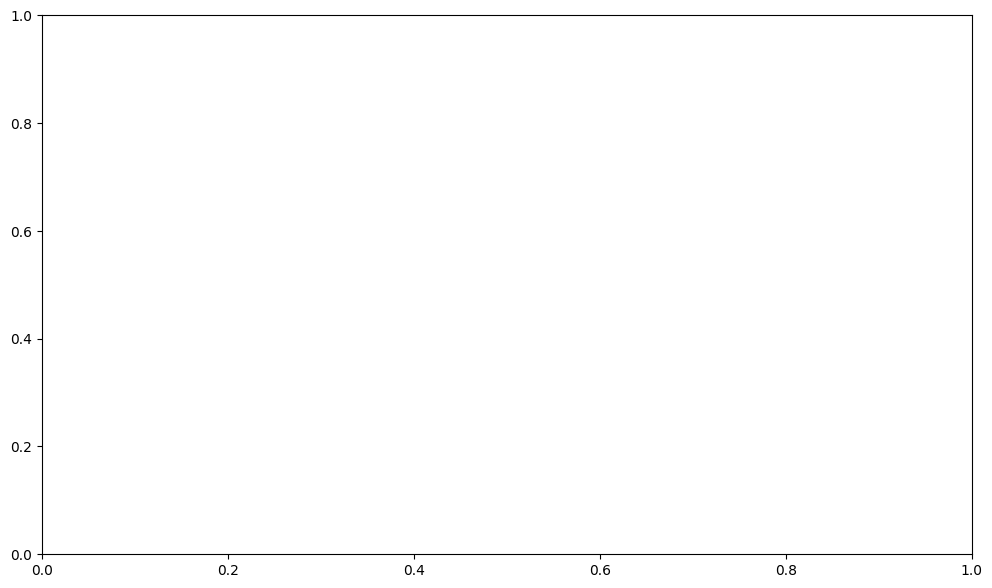

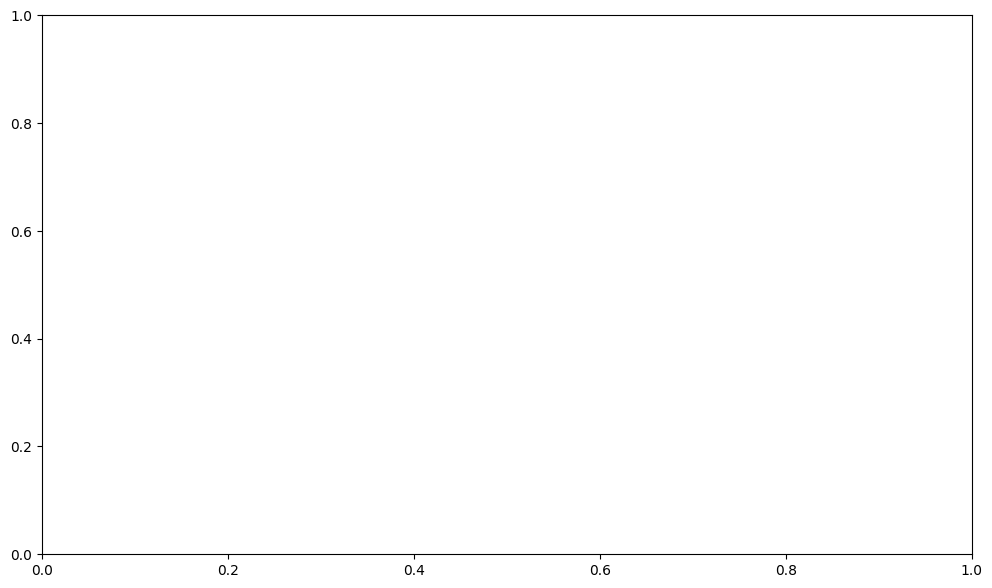

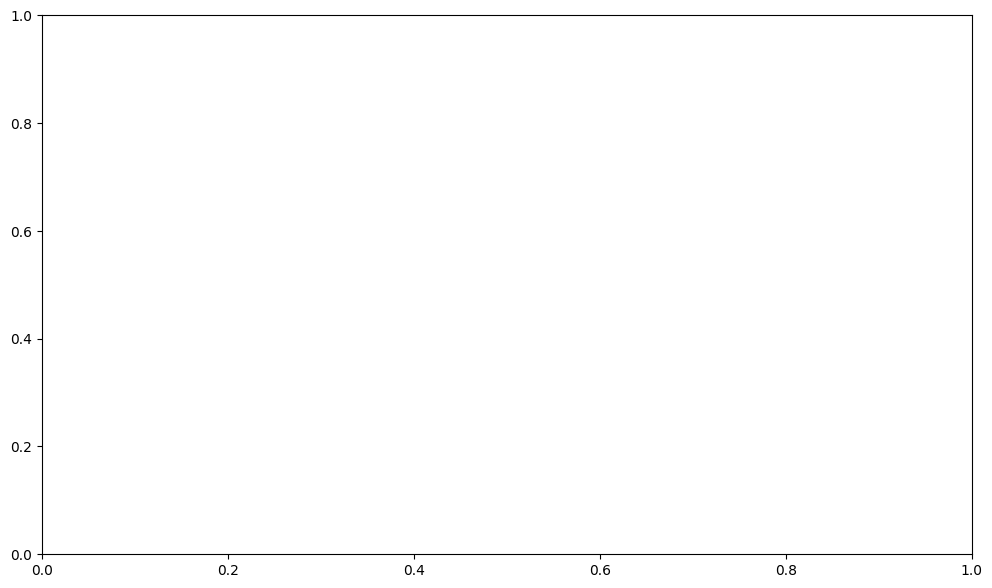

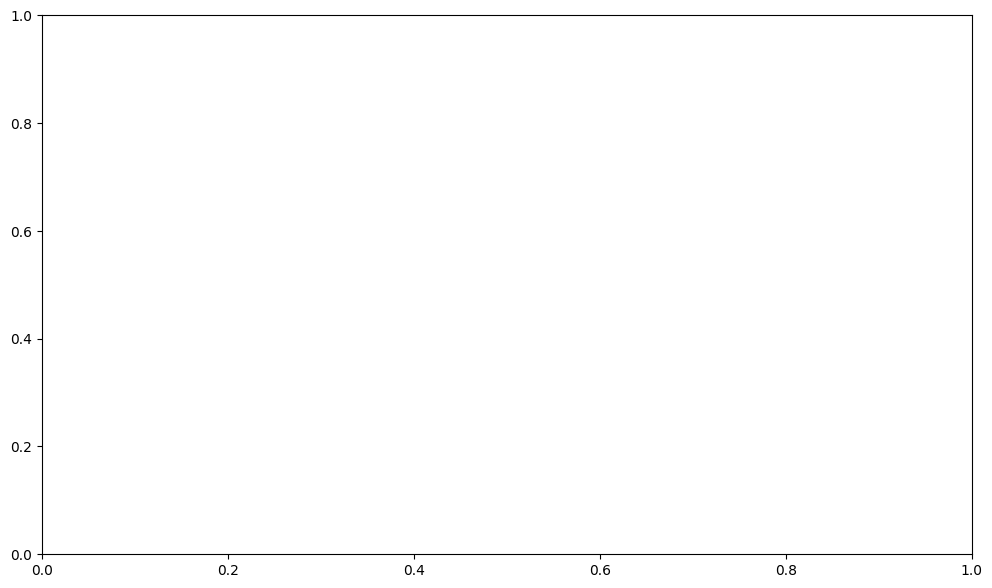

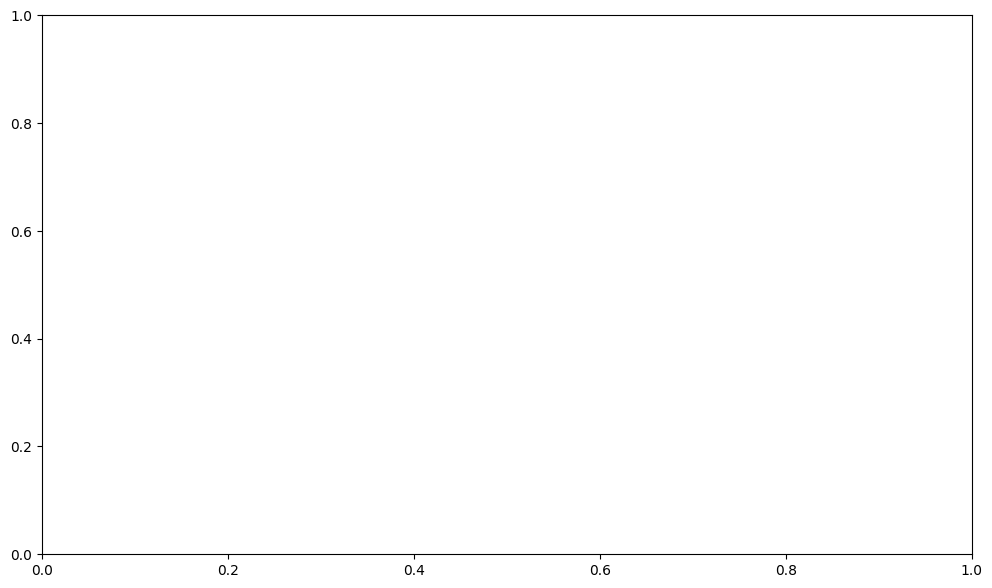

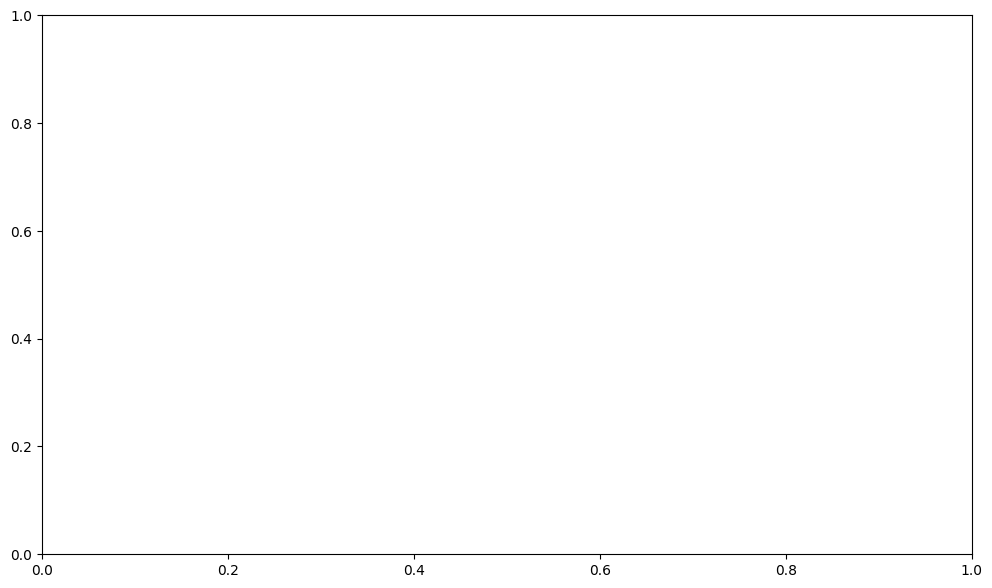

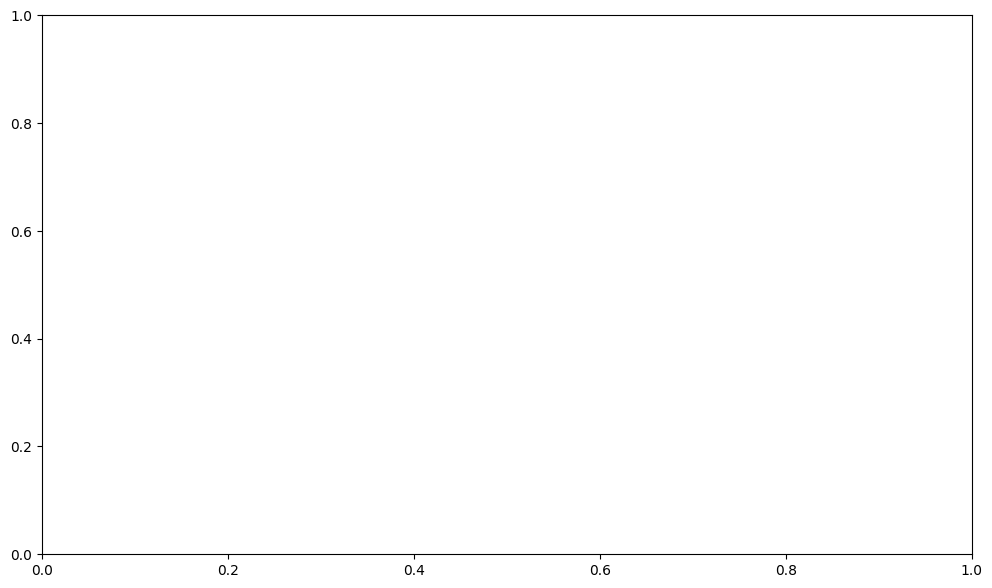

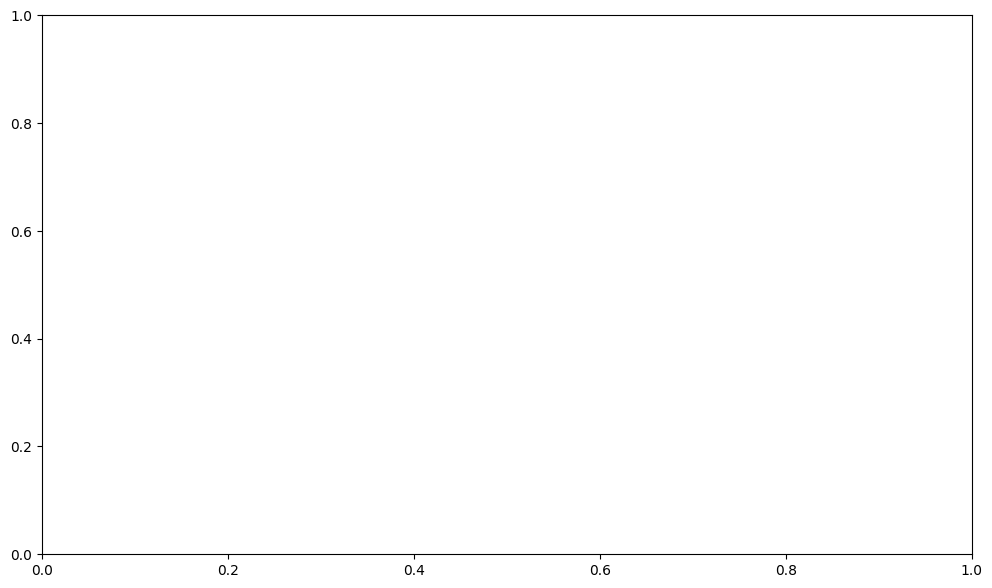

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

data_dict = {}

# for data, target in tqdm(trainloader):
#   if target.item() in data_dict:
#     continue
#   data_dict[target.item()] = data
# #   break
#   if len(data_dict) == 10:
#     break
# net = net.to('cpu')
# net.eval()
net.eval()
for data, target in tqdm(iter(trainloader)):
    if target.item() in data_dict:
        continue
    # data_dict[target.item()] = data
    data =  data.to(device)
    fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
    labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    k = target.item()
    print(f"The target label is: {labels[k]}")
    # break
    spk_rec = forward_pass(net, data).detach().cpu().numpy()
    data_dict[target.item()] = spk_rec
    if len(data_dict) == 10:
        break

In [18]:
idx = 0
for k, spk_rec in data_dict.items():
    # print(spk_rec.shape)
    # 创建一个空白图像，用于绘制动画的每一帧
    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    # 创建一个可写的副本
    frame_writable = frame.copy()

    # 获取脉冲计数数据
    spike_counts = spk_rec[:, idx]
    df = pd.DataFrame(spike_counts)
    df.to_csv(f'spike_count_{k}.csv', index=False)
    # 创建颜色映射
    cmap = plt.get_cmap('viridis')

    # 创建VideoWriter对象
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(f'spike_count_{k}.mp4', fourcc, 10.0, (frame.shape[1], frame.shape[0]))

    # 绘制动画的每一帧
    for t in range(len(spike_counts)):
        # 清空图像
        frame_writable.fill(0)

        # 绘制条形图
        for i, count in enumerate(spike_counts[t]):
            color = cmap(i / len(labels))[:3]
            color = list((np.array(color) * 255).astype(int))
            # print(color)
            color = [0, 255, 0]
            cv2.rectangle(frame_writable, (i * 50, 0), ((i + 1) * 50, int(count * 100)),
                        color, -1)
            cv2.putText(frame_writable, labels[i], (i * 50 + 10, 120), cv2.FONT_HERSHEY_SIMPLEX,
                        1, (255, 255, 255), 2, cv2.LINE_AA)

        # 将当前帧写入视频
        out.write(frame_writable)

    # 释放VideoWriter对象
    out.release()